In [ ]:
#import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import glob
import os
import shutil

import random
from sklearn.model_selection import train_test_split

In [ ]:
#check gpu availability
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
all_image_path = "drive/MyDrive/lemon_quality_dataset/all_dataset/"

In [ ]:
#split good and bad quality images
good_quality_images = [each for each in glob.glob(all_image_path + '/*') if each.split('/')[-1][:4] == "good"]
bad_quality_images = [each for each in glob.glob(all_image_path + '/*') if each.split('/')[-1][:4] == "bad_"]

In [ ]:
#create image:label dictionary for dataset load
good_quality_dict = {each: '0' for each in good_quality_images}
bad_quality_dict = {each: '1' for each in bad_quality_images}
all_images_dict = {**good_quality_dict, **bad_quality_dict}

In [ ]:
#learn the number of images for each class
print("Total good quality image number: ", len(good_quality_images))
print("Total bad quality image number: ", len(bad_quality_images))

Total good quality image number:  1222
Total bad quality image number:  1047


In [ ]:
#split into k folds
k=5
num_good = len(good_quality_images)
good_quality_folds = [good_quality_images[x:x+int(num_good/k+1)] for x in range(0, num_good, int(num_good/k + 1))]

num_bad = len(bad_quality_images)
bad_quality_folds = [bad_quality_images[x:x+int(num_bad/k+1)] for x in range(0, num_bad, int(num_bad/k + 1))]

In [ ]:
#add augmentations
train_transforms = A.Compose(
    [A.RandomBrightnessContrast(p=0.5),
    A.Resize(250,250),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()])

test_transforms = A.Compose(
    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.Resize(250,250),
    ToTensorV2()
    ]
)

In [ ]:
#define a class for the Dataset

class LemonDataset(Dataset):

  def __init__(self, image_paths, transform=False):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = int(all_images_dict[image_filepath])
    if self.transform is not None:
      image = self.transform(image=image)["image"]

    return image, label

In [ ]:
#Define a CNN network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5)
        
        # fully connected layers
        self.fc1 = nn.Linear(256*27*27, 256)
        self.fc2 = nn.Linear(256, 1)

        #normalization layers
        self.conv2_batchnorm = nn.BatchNorm2d(128)
        self.conv3_batchnorm = nn.BatchNorm2d(256)
        self.fc1_batchnorm = nn.BatchNorm1d(256)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2_batchnorm(self.conv2(x))))
        x = self.pool(self.relu(self.conv3_batchnorm(self.conv3(x))))
        x = x.view(-1, 256*27*27) #flatten
        x = self.relu(self.fc1_batchnorm(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        
        return x

In [ ]:
fold_training_loss = []
fold_test_loss = []

def list2str(liste):
  """It converts list of sublists into a list"""

  out = []
  for each in liste:
    for i in each:
      out.append(i)

  return out

for each_fold in range(k):

  #create train(4 folds)-test(1 fold)
  test_image_paths = good_quality_folds[each_fold] + bad_quality_folds[each_fold]
  train_image_paths = list2str([each for index, each in enumerate(good_quality_folds) if index!=each_fold]+[each for index, each in enumerate(bad_quality_folds) if index!=each_fold])

  #shuffle training images
  random.shuffle(train_image_paths)

  #create dataset 
  train_dataset = LemonDataset(train_image_paths, transform=train_transforms)
  test_dataset = LemonDataset(test_image_paths, transform=test_transforms)

  #create dataloaders
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  #call for the model
  model = CNN().to(device)

  #define loss function
  loss_func = nn.BCELoss()
  params = model.parameters()
  optimizer = torch.optim.SGD(params, lr=0.001)
  batch_size = 64
  train_losses = []
  test_losses = []

  #train the model
  num_epochs = 25
  loss_history = []
  print(f"***************{each_fold+1}/{k} step is training...***************")
  
  for epoch in range(num_epochs):

    #training step
    model.train()
    training_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):

      images = images.to(device)
      labels = torch.from_numpy(np.array(labels)).to(torch.float32).to(device)

      optimizer.zero_grad()
      output = model(images)
      loss_train = loss_func(output, labels.unsqueeze(1))
      loss_train.backward()
      optimizer.step()

      if (i+1)%1 == 0:
        print('Epoch [%d/%d], Step [%d/%d], Loss: %4f'
                %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss_train.item()))
      
      #sum training losses coming from batches
      training_loss += loss_train.item()

    #store training losses for each epoch
    train_losses.append(training_loss)
      
    #test step
    model.eval() # important especially for batch normalization layers
    testing_loss = 0.0
    for i, (images, labels) in enumerate(test_loader):

      images = images.to(device)
      labels = torch.from_numpy(np.array(labels)).to(torch.float32).to(device)

      optimizer.zero_grad()
      output = model(images)
      loss = loss_func(output, labels.unsqueeze(1))
      #sum test losses coming from batches
      testing_loss += loss.item()

    #store testing losses for each epoch
    test_losses.append(testing_loss)
  fold_training_loss.append([train_losses])
  fold_test_loss.append([test_losses])


***************1/5 step is training...***************
Epoch [1/25], Step [1/28], Loss: 0.705562
Epoch [1/25], Step [2/28], Loss: 0.476478
Epoch [1/25], Step [3/28], Loss: 0.364046
Epoch [1/25], Step [4/28], Loss: 0.399221
Epoch [1/25], Step [5/28], Loss: 0.318503
Epoch [1/25], Step [6/28], Loss: 0.406717
Epoch [1/25], Step [7/28], Loss: 0.292815
Epoch [1/25], Step [8/28], Loss: 0.335135
Epoch [1/25], Step [9/28], Loss: 0.282736
Epoch [1/25], Step [10/28], Loss: 0.217705
Epoch [1/25], Step [11/28], Loss: 0.247523
Epoch [1/25], Step [12/28], Loss: 0.291781
Epoch [1/25], Step [13/28], Loss: 0.206349
Epoch [1/25], Step [14/28], Loss: 0.254815
Epoch [1/25], Step [15/28], Loss: 0.195573
Epoch [1/25], Step [16/28], Loss: 0.213496
Epoch [1/25], Step [17/28], Loss: 0.142753
Epoch [1/25], Step [18/28], Loss: 0.329347
Epoch [1/25], Step [19/28], Loss: 0.176303
Epoch [1/25], Step [20/28], Loss: 0.251349
Epoch [1/25], Step [21/28], Loss: 0.246738
Epoch [1/25], Step [22/28], Loss: 0.220046
Epoch [1/

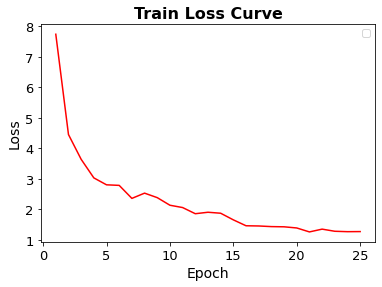

In [ ]:
#plot train-evall loss curves
x_axis = range(1,num_epochs+1)
y_axis1 = train_losses

fig, ax = plt.subplots()
ax.plot(x_axis, y_axis1, color="red")
ax.set_title("Train Loss Curve", fontsize=16, fontweight="bold")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
  label.set_fontsize(13)
ax.legend()

plt.savefig("train_loss_curve.png")

In [ ]:
#measure the performance metrics of the model
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

all_labels = list()
all_predictions = list()
for i,(images, labels) in enumerate(test_loader):

  images = images.to(device)
  labels = labels.to(device).tolist()
  all_labels += labels

  #inform test mode is activated especially for batch normalization layers
  model.eval()

  output = model(images).tolist()
  output = [each[0] for each in output]
  output_rounded = [0 if each<=0.5 else 1 for each in output]
  all_predictions += output_rounded


In [ ]:
print("Accuracy:", accuracy_score(all_labels, all_predictions))
print("Precision:", precision_score(all_labels, all_predictions))
print("Recall:", recall_score(all_labels, all_predictions))
print("F1 score:", f1_score(all_labels, all_predictions))

Accuracy: 0.9821826280623608
Precision: 0.9950248756218906
Recall: 0.966183574879227
F1 score: 0.9803921568627451
